<a href="https://colab.research.google.com/github/GeorgeSherif/NLP-ChatEGP/blob/main/Model%20After%20Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installing & Importing the Necessary Libraries and Mounting the drive**

In [4]:
!pip3 install transformers sentencepiece protobuf torch pygal torchvision sacremoses


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 67.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.7 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895241 sha256=7cc6c5012e27f6f297b4b0c43e5ebc725684be86e58ff7c7ccf397b3f6be8871
  Stored in directory: /root/.cache/pip/wheels/00/24/97/a2ea5324f36bc626e1ea0267f33db6aa80d157ee977e9e42fb
Successfully built sacremoses


In [5]:
from google.colab import drive
from IPython.display import display # Allows the use of display() for DataFrames
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [6]:
import pandas as pd
import numpy as np
import os
import warnings
import csv
import re
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import pygal as py
import matplotlib
plt.rcParams["figure.figsize"] = (8,5)
matplotlib.rc('xtick', labelsize=7) 
matplotlib.rc('ytick', labelsize=7) 

import torch
import torchvision

from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline 

In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# **Approach 1: Evaluate the English Model (BERT)**


*   English Train Data
*   Arabic Test Data
*   Train with the English Dataset
*   Translate the Arabic Dataset
*   Evaluate Model





### Load the English Dataset

In [8]:
#df = pd.read_csv('/content/gdrive/MyDrive/NLP/English Dataset.csv' ,engine="python", encoding = "ISO-8859-1")
df = pd.read_csv('/content/gdrive/MyDrive/NLP/Preprocessed.csv' ,engine="python", encoding = "ISO-8859-1")
print((df['Sentiment'] == 'neutral').sum())


2879


In [9]:
num_entries_to_remove_positive = (df['Sentiment'] == 'positive').sum() - (df['Sentiment'] == 'negative').sum()
num_entries_to_remove_neutral = (df['Sentiment'] == 'neutral').sum() - (df['Sentiment'] == 'negative').sum()
print(num_entries_to_remove_neutral)


indices_to_remove = df[df['Sentiment'] == 'positive'].sample(num_entries_to_remove_positive).index
dfPositive = df[df['Sentiment'] == 'positive'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'neutral'].sample(num_entries_to_remove_neutral).index
dfNeutral = df[df['Sentiment'] == 'neutral'].drop(indices_to_remove)

indices_to_remove = df[df['Sentiment'] == 'negative'].sample(0).index
dfNegative = df[df['Sentiment'] == 'negative'].drop(indices_to_remove)

print(dfNegative)

2275
     Sentiment                                           Sentence
2     negative    The international electronic industry compan...
415   negative    A tinyurl link takes users scamming site pro...
421   negative    Compared FTSE 100 index rose 36.7 points ( 0...
423   negative    Compared FTSE 100 index rose 94.9 points ( 1...
500   negative    One challenges oil production North Sea scal...
...        ...                                                ...
4840  negative    HELSINKI Thomson Financial - Shares Cargotec...
4841  negative    LONDON MarketWatch -- Share prices ended low...
4843  negative    Operating profit fell EUR 35.4 mn EUR 68.8 m...
4844  negative    Net sales Paper segment decreased EUR 221.6 ...
4845  negative    Sales Finland decreased 10.5 % January sales...

[604 rows x 2 columns]


In [10]:
dfNew = pd.concat((dfNegative, dfNeutral, dfPositive), axis = 0)
dfNew
df = dfNew

In [11]:
df['Sentiment'] = df['Sentiment'].replace(['negative','neutral','positive'],[0,1,2])
df

,Sentiment,Sentence
2,0,The international electronic industry compan...
415,0,A tinyurl link takes users scamming site pro...
421,0,Compared FTSE 100 index rose 36.7 points ( 0...
423,0,Compared FTSE 100 index rose 94.9 points ( 1...
500,0,One challenges oil production North Sea scal...
...,...,...
4536,2,Key shareholders Finnish IT services provide...
4575,2,As part transaction M-real Sappi also signed...
4774,2,`` I extremely delighted project continuatio...
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent...


<Axes: xlabel='count', ylabel='Sentiment'>

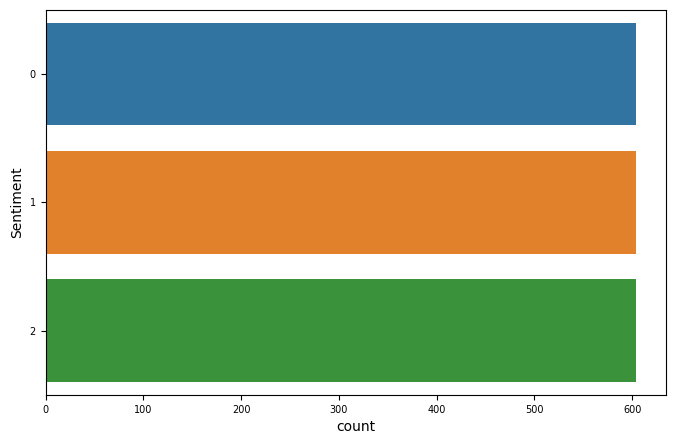

In [12]:
sns.countplot(y="Sentiment",data=df)

In [13]:
df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)
df

,Sentiment,Sentence
2,0,The international electronic industry compan...
415,0,A tinyurl link takes users scamming site pro...
421,0,Compared FTSE 100 index rose 36.7 points ( 0...
423,0,Compared FTSE 100 index rose 94.9 points ( 1...
500,0,One challenges oil production North Sea scal...
...,...,...
4536,2,Key shareholders Finnish IT services provide...
4575,2,As part transaction M-real Sappi also signed...
4774,2,`` I extremely delighted project continuatio...
4786,2,Danske Bank A-S DANSKE DC jumped 3.7 percent...


### Sentiment Analysis using BERT

In [41]:
from sklearn.model_selection import train_test_split
X_features = df["Sentence"]
Y_features = df["Sentiment"]
X_train, X_val, y_train, y_val = train_test_split(df.index.values, df.Sentiment.values, test_size=0.2, random_state=42, shuffle=True)

In [42]:
from transformers import BertTokenizer,BertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      id2label={0: 'negative', 1: 'neutral', 2: 'positive'},
                                                      output_attentions = False,
                                                      output_hidden_states = False).to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [43]:
df['data_type'] = ['not_set'] * df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

#groupby count
df.groupby([ 'Sentiment', 'data_type']).count()
#df = df.rename(columns={'Review Text': 'Sentence'})
df[df.data_type == 'train'].Sentence.values


array(['  The international electronic industry company Elcoteq laid tens employees Tallinn facility contrary earlier layoffs company contracted ranks office workers daily Postimees reported',
       '  A tinyurl link takes users scamming site promising users earn thousands dollars becoming Google ( NASDAQ GOOG ) Cash advertiser',
       '  Compared FTSE 100 index rose 36.7 points ( 0.6 % ) day relative price change -0.2 %',
       ...,
       '  `` I extremely delighted project continuation cooperation Viking Line',
       '  Danske Bank A-S DANSKE DC jumped 3.7 percent 133.4 kroner rebounding yesterday 3.5 percent slide',
       '  Our superior customer centricity expertise digital services set us apart competitors'],
      dtype=object)

In [31]:
#encode train set
encoded_data_train = tokenizer.batch_encode_plus(df[df.data_type == 'train'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')
                                                
#encode validation set
encoded_data_val = tokenizer.batch_encode_plus( df[df.data_type == 'val'].Sentence.values,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                max_length = 150,
                                                truncation=True,
                                                return_tensors = 'pt')

In [32]:
#train set
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type == 'train'].Sentiment.values)

#validation set
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type == 'val'].Sentiment.values)
     

In [33]:
from torch.utils.data import TensorDataset

#train set
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

#validation set
dataset_val = TensorDataset(input_ids_val, 
                             attention_masks_val, 
                             labels_val)

In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 8

#train set
dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

#validation set
dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = batch_size) #since we don't have to do backpropagation for this step

In [35]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-7) #2e-5 > 5e-5
                 
epochs = 8

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps =len(dataloader_train)*epochs)


In [36]:
def evaluate(dataloader_val):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [37]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis = 1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [38]:
#accuracy score
def accuracy_per_class(preds, labels):
    #label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    correct = 0
    total = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n -> {len(y_preds[y_preds==label]) / len(y_true)}')
        correct = correct + len(y_preds[y_preds==label])
        total = total + len(y_true)
    return correct / total

In [39]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [40]:
from tqdm import tqdm

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc = 'Epoch {:1d}'.format(epoch), 
                        leave = False, 
                        disable = False)
    
    for batch in progress_bar:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/NLP/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\n Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    true_vals.shape
    accuracy = accuracy_per_class(predictions, true_vals)

    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    tqdm.write(f'Accuracy Score: {accuracy}')

  0%|          | 0/8 [37:02<?, ?it/s]


 Epoch {epoch}
Training loss: {loss_train_avg}



 12%|█▎        | 1/8 [39:57<4:39:39, 2397.02s/it]

Accuracy:106/128
 -> 0.828125
Accuracy:60/107
 -> 0.5607476635514018
Accuracy:94/128
 -> 0.734375
Validation loss: 0.682885155081749
F1 Score (weighted): 0.7143828351789917
Accuracy Score: 0.7162534435261708



 12%|█▎        | 1/8 [1:16:25<4:39:39, 2397.02s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 25%|██▌       | 2/8 [1:19:20<3:57:43, 2377.27s/it]

Accuracy:113/128
 -> 0.8828125
Accuracy:84/107
 -> 0.7850467289719626
Accuracy:78/128
 -> 0.609375
Validation loss: 0.5827840845222059
F1 Score (weighted): 0.7543843782971115
Accuracy Score: 0.7575757575757576



 25%|██▌       | 2/8 [1:55:59<3:57:43, 2377.27s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 38%|███▊      | 3/8 [1:58:53<3:17:57, 2375.50s/it]

Accuracy:113/128
 -> 0.8828125
Accuracy:77/107
 -> 0.719626168224299
Accuracy:96/128
 -> 0.75
Validation loss: 0.5526419838323541
F1 Score (weighted): 0.7867292135664036
Accuracy Score: 0.7878787878787878



 38%|███▊      | 3/8 [2:35:28<3:17:57, 2375.50s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 50%|█████     | 4/8 [2:38:24<2:38:13, 2373.49s/it]

Accuracy:113/128
 -> 0.8828125
Accuracy:84/107
 -> 0.7850467289719626
Accuracy:89/128
 -> 0.6953125
Validation loss: 0.6177199196232401
F1 Score (weighted): 0.7867599857949756
Accuracy Score: 0.7878787878787878



 50%|█████     | 4/8 [3:15:05<2:38:13, 2373.49s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 62%|██████▎   | 5/8 [3:17:55<1:58:37, 2372.59s/it]

Accuracy:111/128
 -> 0.8671875
Accuracy:69/107
 -> 0.6448598130841121
Accuracy:112/128
 -> 0.875
Validation loss: 0.737116464069518
F1 Score (weighted): 0.8026840645134823
Accuracy Score: 0.8044077134986226



 62%|██████▎   | 5/8 [3:54:44<1:58:37, 2372.59s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 75%|███████▌  | 6/8 [3:57:39<1:19:13, 2376.66s/it]

Accuracy:110/128
 -> 0.859375
Accuracy:79/107
 -> 0.7383177570093458
Accuracy:104/128
 -> 0.8125
Validation loss: 0.7868337020196993
F1 Score (weighted): 0.8076114122784048
Accuracy Score: 0.8071625344352618



 75%|███████▌  | 6/8 [4:34:28<1:19:13, 2376.66s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



 88%|████████▊ | 7/8 [4:37:24<39:39, 2379.44s/it]  

Accuracy:112/128
 -> 0.875
Accuracy:75/107
 -> 0.7009345794392523
Accuracy:110/128
 -> 0.859375
Validation loss: 0.8398268774819925
F1 Score (weighted): 0.8171412241555298
Accuracy Score: 0.8181818181818182



 88%|████████▊ | 7/8 [5:14:19<39:39, 2379.44s/it]


 Epoch {epoch}
Training loss: {loss_train_avg}



100%|██████████| 8/8 [5:17:19<00:00, 2379.99s/it]

Accuracy:112/128
 -> 0.875
Accuracy:77/107
 -> 0.719626168224299
Accuracy:109/128
 -> 0.8515625
Validation loss: 0.8471860542397379
F1 Score (weighted): 0.8206512342636693
Accuracy Score: 0.8209366391184573


In [47]:
_, predictions, true_vals = evaluate(dataloader_val)

100%|██████████| 46/46 [03:03<00:00,  3.98s/it]


In [48]:
true_vals.shape
accuracy_per_class(predictions, true_vals)

Accuracy:0/128
 -> 0.0
Accuracy:0/107
 -> 0.0
Accuracy:128/128
 -> 1.0


0.3526170798898072